In [1]:
import os
import librosa
import math
import json
import matplotlib.pyplot as plt
import numpy as np
import json
import numpy as np
from keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow import keras
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
import scipy.io as sio


In [2]:
dataset_path = r"Data/genres_original"
json_path = "data.json"
SAMPLE_RATE = 22050
DURATION = 29
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
hop_length = 512
expected_length = math.ceil(SAMPLES_PER_TRACK / hop_length)


In [19]:

def plot_history(hist):
    plt.figure(figsize=(20, 15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="validation accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    axs[0].grid()

    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    axs[1].grid()

    plt.show()


# load data from json file
def load_data():
    # with open(dataset_path,"r") as f:
    #     data = json.load(f)
    #
    # # Convert list to numpy arrays
    # inputs = np.array(data["mfcc"])
    # targets = np.array(data["labels"])

    data = sio.loadmat("data.mat")
    inputs = data["mfcc"]
    targets = np.array(data["labels"])

    return inputs, targets

def prepare_dataset(test_size, validation_size):
    X, y = load_data()
    y = y.reshape(-1)
    X_train, X_test, y_train, y_test = train_test_split(X[:,:,1:500], y, test_size=test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [20]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.2, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2])
print(X_train.shape)
print(input_shape)

(639, 20, 499)
(20, 499)


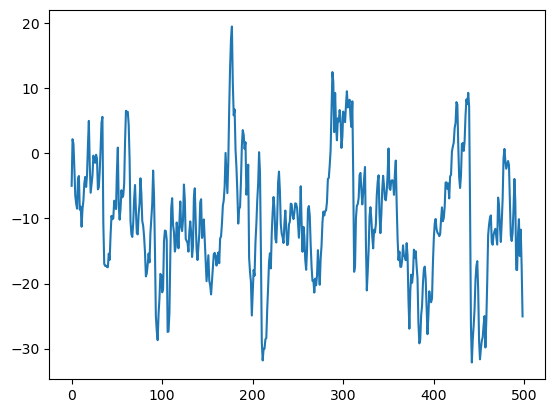

In [21]:
plt.plot(X_train[1,10,:])

In [36]:
model = Sequential()
model.add(LSTM(20, input_shape=input_shape, return_sequences = True, activity_regularizer=regularizers.L2(1e-3)))
model.add(Dropout(0.3))
model.add(LSTM(20, input_shape=input_shape, activity_regularizer=regularizers.L2(1e-3)))
model.add(Dropout(0.3))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

# model = Sequential()
# model.add(LSTM(10, input_shape=input_shape, activity_regularizer=regularizers.L2(1e-3), ))
# model.add(Dropout(0.3))
# model.add(LSTM(10, input_shape=input_shape, activity_regularizer=regularizers.L2(1e-3), ))
# model.add(Dropout(0.3))
# model.add(Dense(10, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 20)            41600     
                                                                 
 dropout_5 (Dropout)         (None, 20, 20)            0         
                                                                 
 lstm_5 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_6 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 10)               

In [37]:
K.clear_session()

model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data=(X_val, y_val),
                 epochs=100,
                 batch_size=100)

Epoch 1/100
7/7 [==============================] - 3s 111ms/step - loss: 2.3926 - accuracy: 0.1049 - val_loss: 2.3809 - val_accuracy: 0.0938
Epoch 2/100
7/7 [==============================] - 0s 28ms/step - loss: 2.3647 - accuracy: 0.1002 - val_loss: 2.3643 - val_accuracy: 0.1125
Epoch 3/100
7/7 [==============================] - 0s 26ms/step - loss: 2.3501 - accuracy: 0.0955 - val_loss: 2.3532 - val_accuracy: 0.1312
Epoch 4/100
7/7 [==============================] - 0s 19ms/step - loss: 2.3358 - accuracy: 0.1502 - val_loss: 2.3488 - val_accuracy: 0.1312
Epoch 5/100
7/7 [==============================] - 0s 17ms/step - loss: 2.3279 - accuracy: 0.1205 - val_loss: 2.3459 - val_accuracy: 0.1500
Epoch 6/100
7/7 [==============================] - 0s 15ms/step - loss: 2.3199 - accuracy: 0.1393 - val_loss: 2.3413 - val_accuracy: 0.1437
Epoch 7/100
7/7 [==============================] - 0s 15ms/step - loss: 2.3125 - accuracy: 0.1596 - val_loss: 2.3393 - val_accuracy: 0.1750
Epoch 8/100
7/7 [==

In [ ]:

plot_history(hist)

In [ ]:

test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")